In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

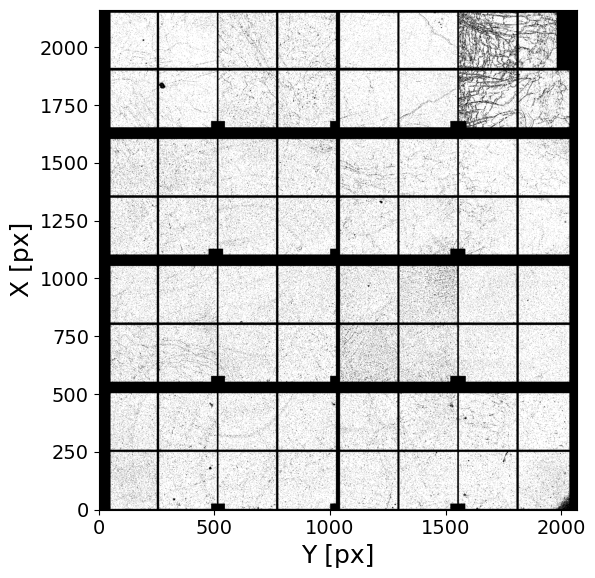

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

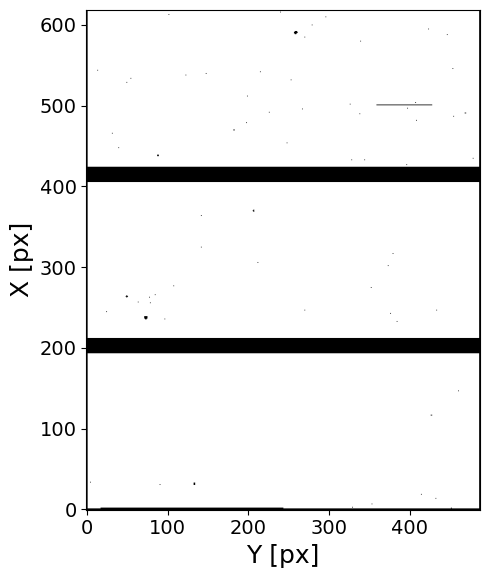

In [3]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [4]:
###########
Q = 0.33
dq = 0.01
###########
Q=float(Q)

## XPCS scan: delcoup=1.7, T=24h (Ta2O5_2.5um_asdep, 2, 1)  

Tantala as deposited

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =2
Nscan = 1
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, NotImplemented
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  4.374549666666667 h
theta = 1.6999999999999993
Qc = 0.33
#############################



NameError: name 'Q' is not defined

### Flux check

################################################################################
Maximum count in the whole run -> 2.0
# of pixels above Ith_high treshold ->  4315901 pixels (of 4471016 => 96.53 %)
# of pixels below Ith_low treshold ->  119349 pixels (of 4471016 => 2.67 %)
################################################################################



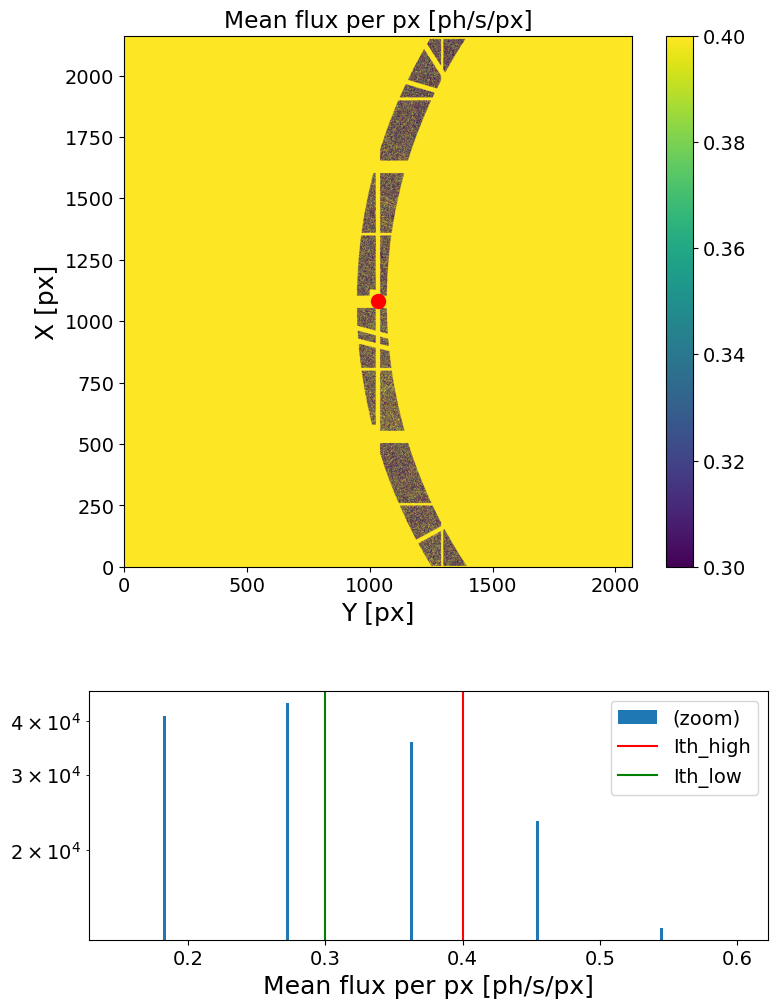

In [6]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.3, Ith_high=0.4, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [7]:
####################
Lbin = 100
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

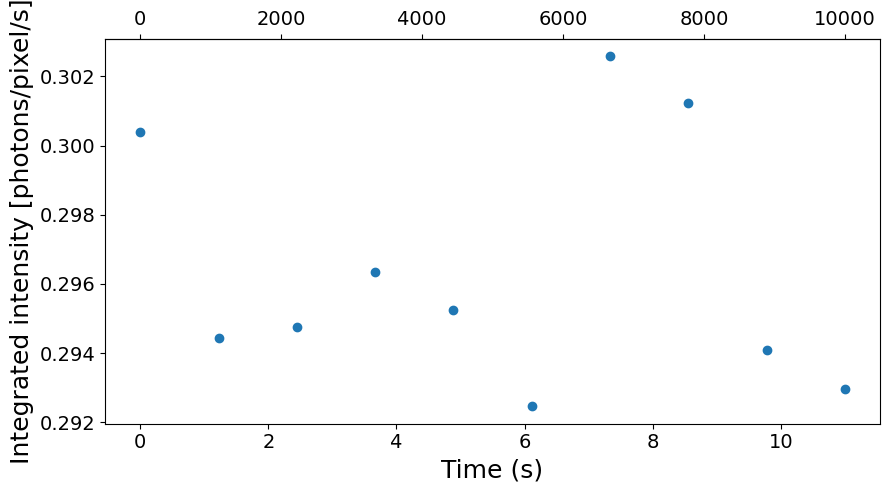

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Pilatus

In [ ]:
##############################################################################
Nfi, Nff =  0, None
Nstep = 3000
#######################################

pilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, Nstep=Nstep)

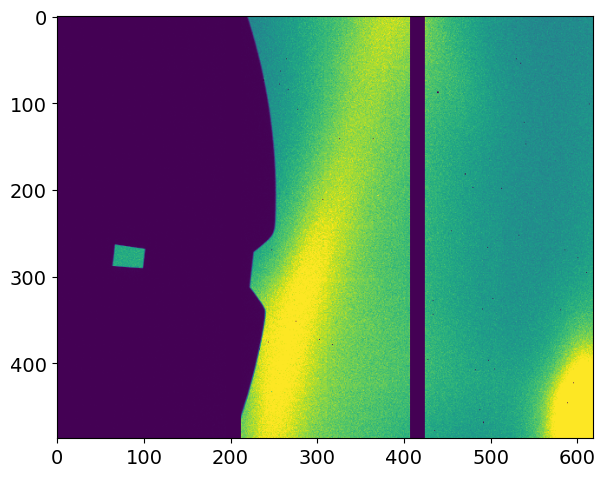

In [10]:
#################
Nf_pilatus = 0
#################

plt.figure(figsize=(10, 5))
plt.imshow(pilatus_data[Nf_pilatus].T, vmin=0, vmax=500)
plt.tight_layout(); plt.show()

Computing azimuthal integration...


100%|██████████| 3/3 [00:00<00:00, 23.28it/s]

Done! (elapsed time = 0.13 s)


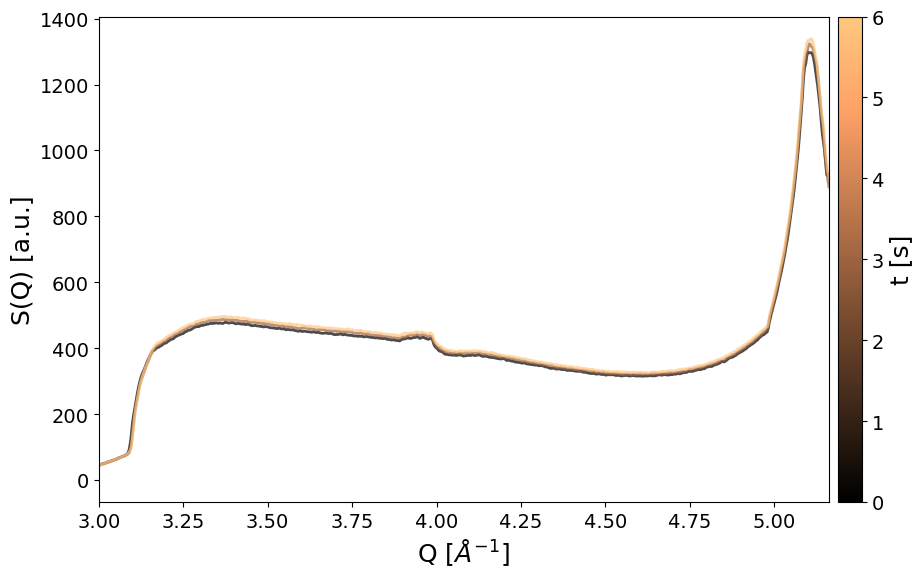

In [11]:
q, Sq, dSq = XPCS.get_Sq(pilatus_data, ponifile=pilatus_LaB6_poni, mask=pilatus_mask)
XPCS.plot_Sq(q, Sq, itime=2, xlims=(3,q[-1]))

### Linear correlation 4 tests

In [28]:
###################
Nfi = None
Nff = int(1e6)
Lbin = 100
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 0.3 s)
	 | 10000 frames X 202076 pixels
	 | memory usage (np.array @ float32) = 7.528 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 13.68 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.48 s)



In [7]:
############################
t1, t2 = 0, 15000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [29]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.06 s)



In [30]:
for i in range(g2[t_bunch].shape[0]):
    print(i, dg2[t_bunch][i]/g2[t_bunch][i]*100)

0 0.06642032
1 0.066825695
2 0.06623948
3 0.066815466
4 0.06639155
5 0.067221634
6 0.06659047
7 0.066339
8 0.06722537
9 0.06617425
10 0.067738965
11 0.066140786
12 0.06709626
13 0.066965036
14 0.0670974
15 0.066814356
16 0.066916406
17 0.06632383
18 0.06683355
19 0.06670903
20 0.06687584
21 0.06706358
22 0.06673287
23 0.06716495
24 0.0661176
25 0.06731047
26 0.067382194
27 0.066470936
28 0.066621535
29 0.06706384
30 0.06665711
31 0.066706724
32 0.066996984
33 0.06673907
34 0.06733637
35 0.066664755
36 0.06604707
37 0.06674739
38 0.06685076
39 0.06636865
40 0.0667651
41 0.06647589
42 0.06704877
43 0.067083426
44 0.066400915
45 0.06715295
46 0.06626971
47 0.066773765
48 0.06705143
49 0.066828616
50 0.06602858
51 0.06617367
52 0.06637964
53 0.066400915
54 0.0656925
55 0.06837364
56 0.06625397
57 0.06718118
58 0.06680716
59 0.06828497
60 0.067279615
61 0.067452915
62 0.06666689
63 0.06595363
64 0.06701194
65 0.067029804
66 0.06673976
67 0.066054374
68 0.06717506
69 0.0665445
70 0.06722417


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


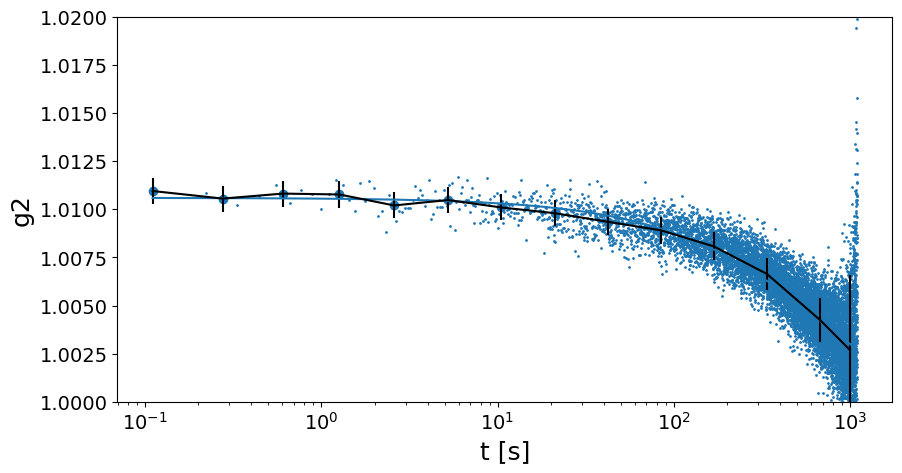

name,value,standard error,relative error,initial value,min,max,vary
tau,675.719074,36.7381568,(5.44%),1000,0.00000000,1000000.00,True
beta,0.84520337,0.05990410,(7.09%),1,0.00000000,2.00000000,True
c,0.01009617,1.1338e-04,(1.12%),0.02,0.00000000,1.00000000,True
y0,1.00050000,0.00000000,(0.00%),1.0005,-inf,inf,False


In [33]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.0005, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k],yerr=dg2_mt[k], c='black', label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    x = t_mt[k] [(t1_fit<t_mt[k])*(t_mt[k]<t2_fit)]
    y = g2_mt[k][(t1_fit<t_mt[k])*(t_mt[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

In [37]:
print(dg2[k][-4])

0.016091071


Exception ignored in: <function ResourceTracker.__del__ at 0x7ff4456ffc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fc51126bc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

### Linear by dose

In [ ]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 13839111  =>  t_ff = 15223.0221
#############################



In [ ]:
########################################
tt = np.linspace(0, int(t_ff), 5)
########################################

t_segments = [(tt[i], tt[i+1]) for i in range(len(tt)-1)]
Nf_segments =  [(int(t_segments[i][0]//itime), int(t_segments[i][1]//itime)) for i in range(len(t_segments))]

In [ ]:
from contextlib import redirect_stdout
import io

###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2= {}, {}
for i in tqdm(range(len(Nf_segments))):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i][0]
        Nff = Nf_segments[i][1]
        G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

        t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
        t_g2[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2)

100%|██████████| 4/4 [01:23<00:00, 20.90s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

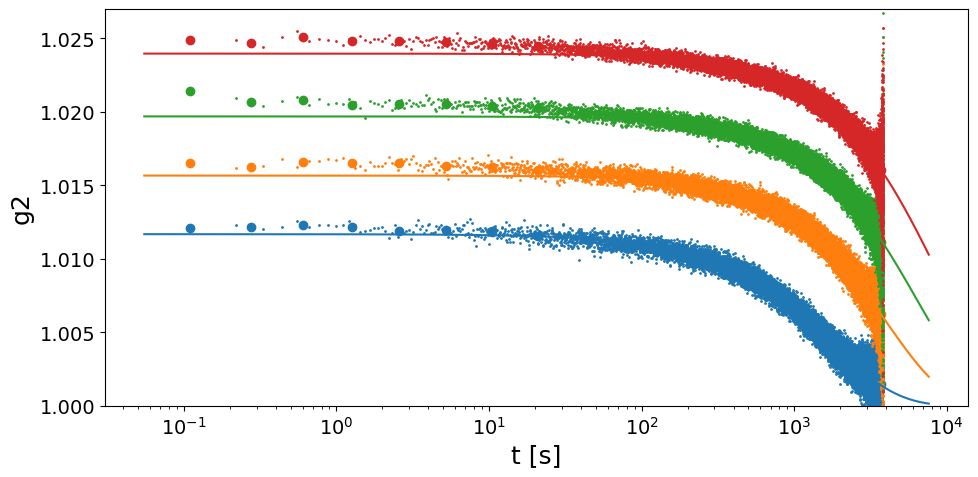

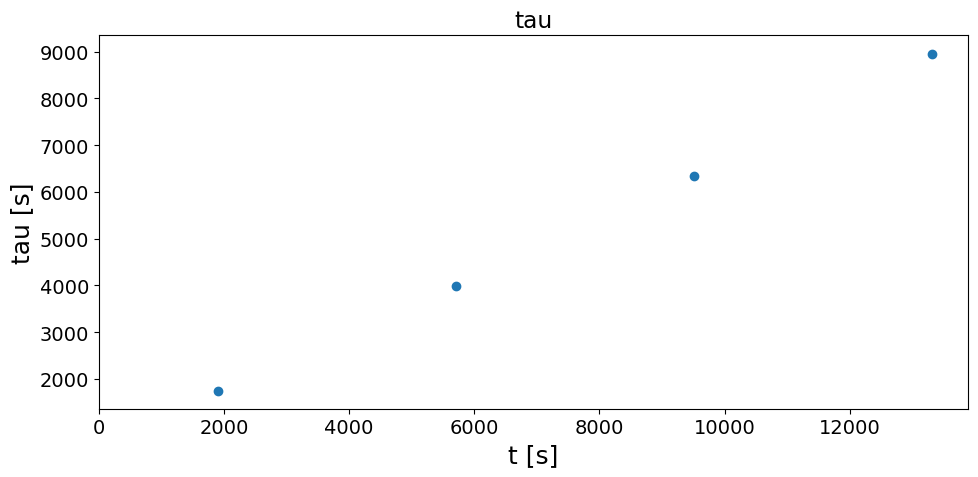

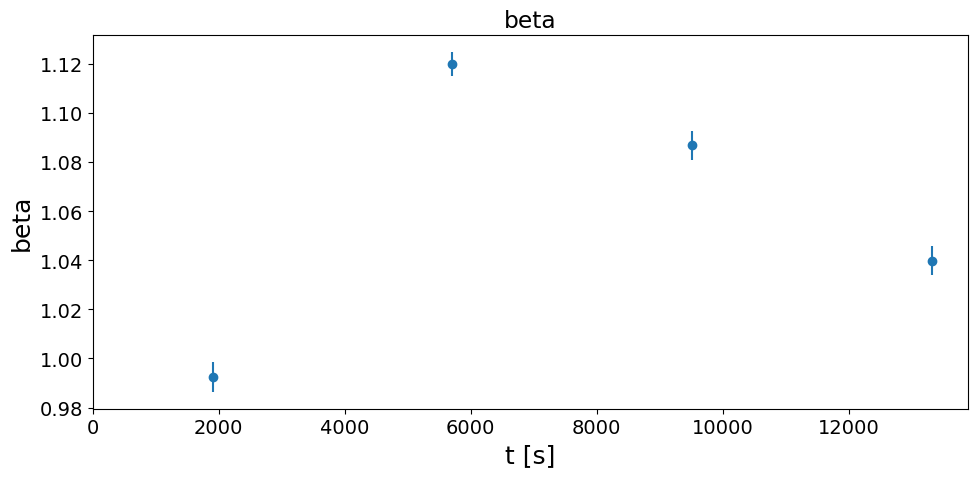

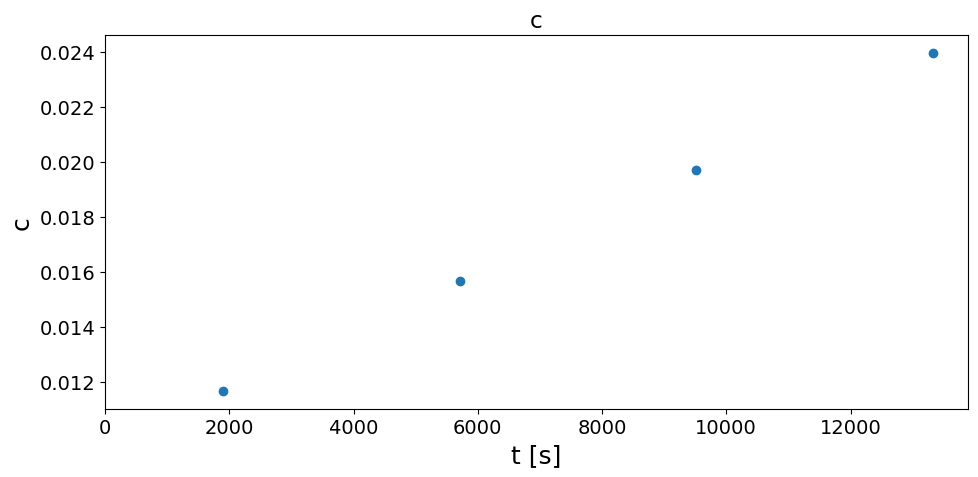

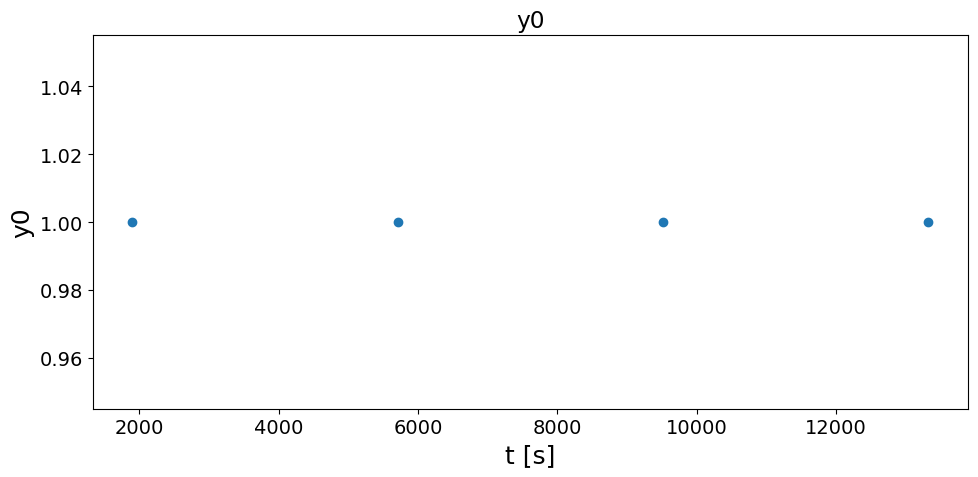

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k])
    plt.scatter(t_mt, g2_mt, c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k])/2, np.max(t_g2[k])*2, 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.027)
#plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

### Multi-tau Correlation (TO BE REORDER!!!)

In [ ]:
XPCS.print_Nf_choices(len(scan['fast_timer_period']))

       Nf = 6012328    =>    log2(Nf) = 22.52
----------------------------------------------------
   reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0       2**22                 21             30.2        1818024
1     5*2**20                 19             13.0         769448
2    11*2**19                 18              4.0         245160
3    45*2**17                 16              2.0         114088
4    91*2**16                 15              1.0          48552
5   183*2**15                 14              0.0          15784
6   733*2**13                 12              0.0           7592
7  1467*2**12                 11              0.0           3496
----------------------------------------------------


In [ ]:
##### INPUTS #####
Nfi = 0
Nff = 0 +1*2**22
sparse_depth = 13
dense_depth = 21
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

Loading frames ...
Done! (elapsed time = 2.72 s)
	 | 4194304 frames X 202076 pixels
	 | sparsity = 3.63e-04
	 | memory usage (sparse.csr_array @ float32) = 3.468 GB
Computing sparse multitau G2t...


100%|██████████| 512/512 [01:27<00:00,  5.82it/s]


Done! (elapsed time = 87.96 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:00<00:00, 35.55it/s]

Done! (elapsed time = 0.23 s)


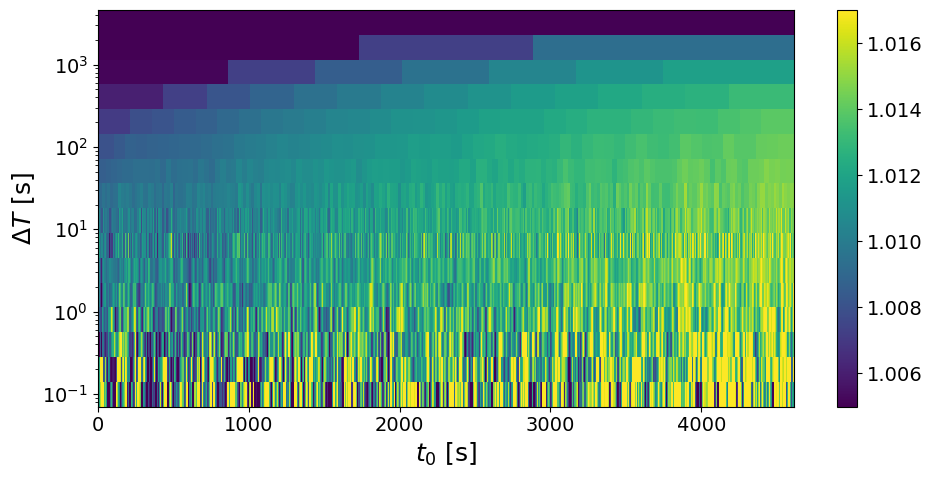

In [ ]:
############################
vmin, vmax = 1.005, 1.017
lower_mt = 6
filter_layer = 12
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, filter_layer=filter_layer)

In [ ]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, tmin=None, tmax=3000)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, tmin=3000, tmax=6000)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, tmin=6000, tmax=15000)
t_mt_1, g2_mt_1, dg2_mt_1 = XPCS.get_g2mt(itime, cut1)
t_mt_2, g2_mt_2, dg2_mt_2 = XPCS.get_g2mt(itime, cut2)
t_mt_3, g2_mt_3, dg2_mt_3 = XPCS.get_g2mt(itime, cut3)

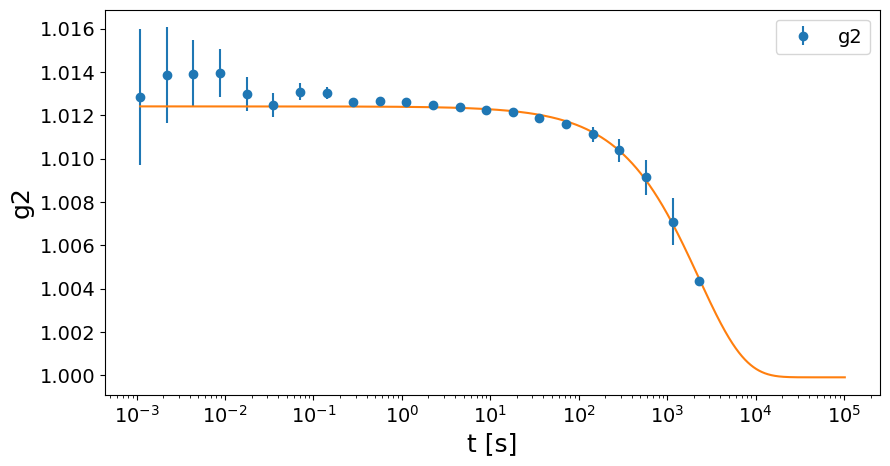

tau = 2278.4462895214124 +/- 980.3358234853137
beta = 0.8327289412512385 +/- 0.0798632634225064
c = 0.012514664192682625 +/- 0.0027602589650978534
y0 = 0.9999000000000001 +/- 0.002718059032489621


In [ ]:
##################
t1_fit = 1
t2_fit = 1e8
##################

plt.figure(figsize=(10,5))
plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')
#plt.errorbar(t_mt_1, g2_mt_1, yerr=dg2_mt_1, fmt='o', label='CUT1')
#plt.errorbar(t_mt_2, g2_mt_2, yerr=dg2_mt_2, fmt='o', label='CUT2')
#plt.errorbar(t_mt_3, g2_mt_3, yerr=dg2_mt_3, fmt='o', label='CUT3')


popt, pcov = curve_fit(decorrelation_f, t_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], g2_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], p0=[1000, .8, .04, 1], bounds=([0, 0, 0, .9999], [np.inf, np.inf, np.inf, 1.1]))
x = np.arange(np.min(t_mt), np.max(t_mt)+1e5, 1e-2)
y = decorrelation_f(x, *popt)
plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()


print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')


## XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 4, 5)  

Tantala as deposited

#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.888928 h
theta = 1.6999999999999993
Qc = 0.33
#############################



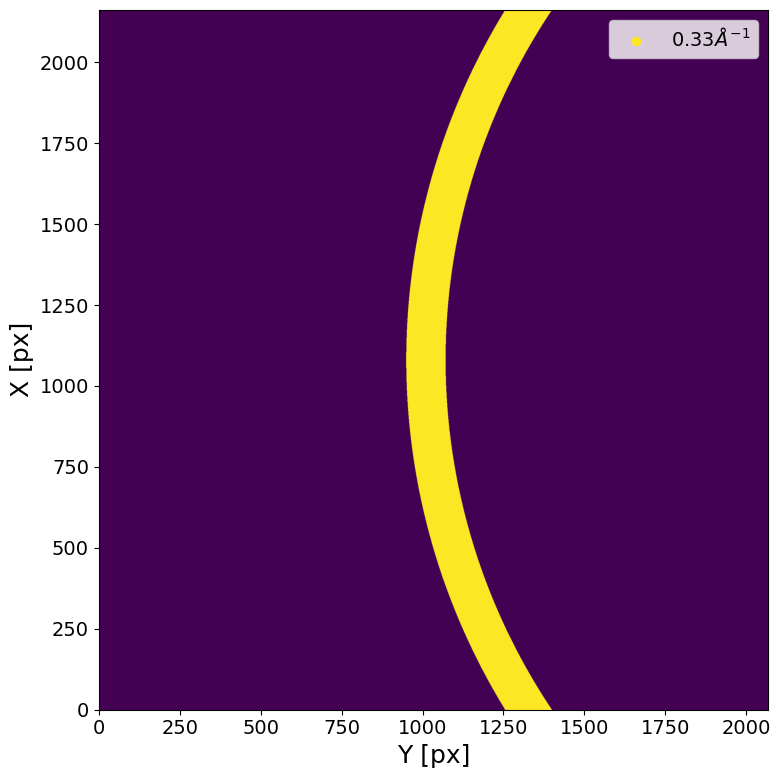

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00030.h5 (31/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00032.h5 (33/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00033.h5 (34/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00034.h5 (35/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00035.h5 (36/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00037.h5 (38/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00039.h5 (40/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00040.h5 (41/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00041.h5 (42/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00042.h5 (43/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00043.h5 (44/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00044.h5 (45/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00045.h5 (46/3201 loops)
	 -> loadi

In [16]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 5
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 4.0
# of pixels above Ith_high treshold ->  4301327 pixels (of 4471016 => 96.2 %)
# of pixels below Ith_low treshold ->  1 pixels (of 4471016 => 0.0 %)
################################################################################



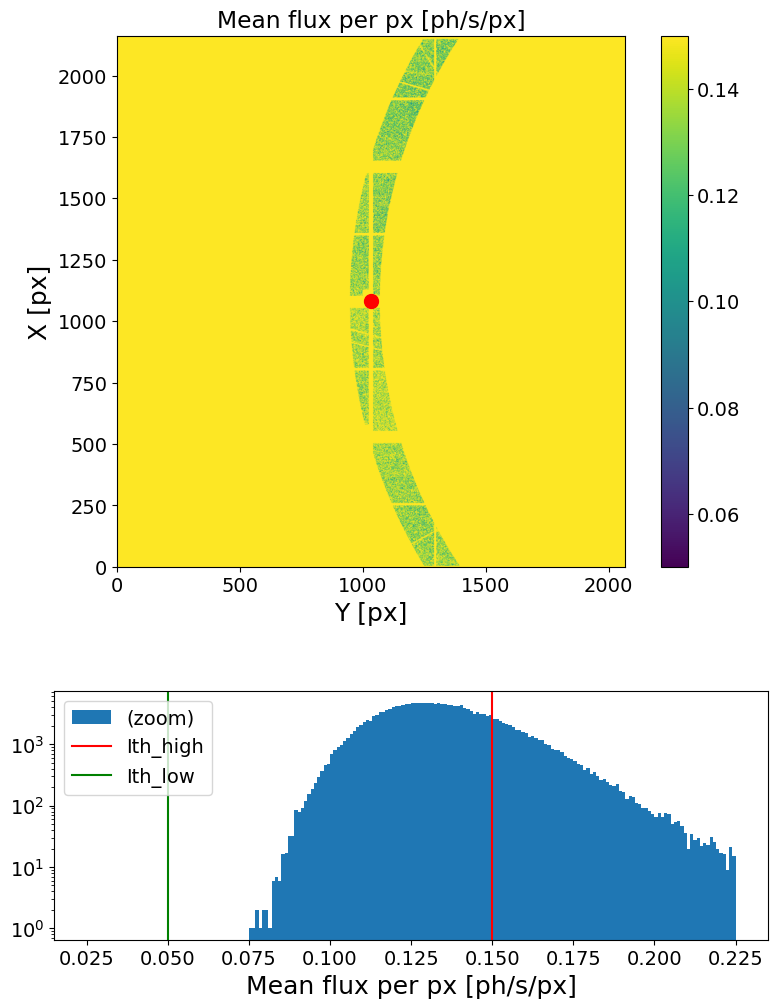

In [17]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.05, Ith_high=0.15, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [18]:
####################
Lbin = 1000
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

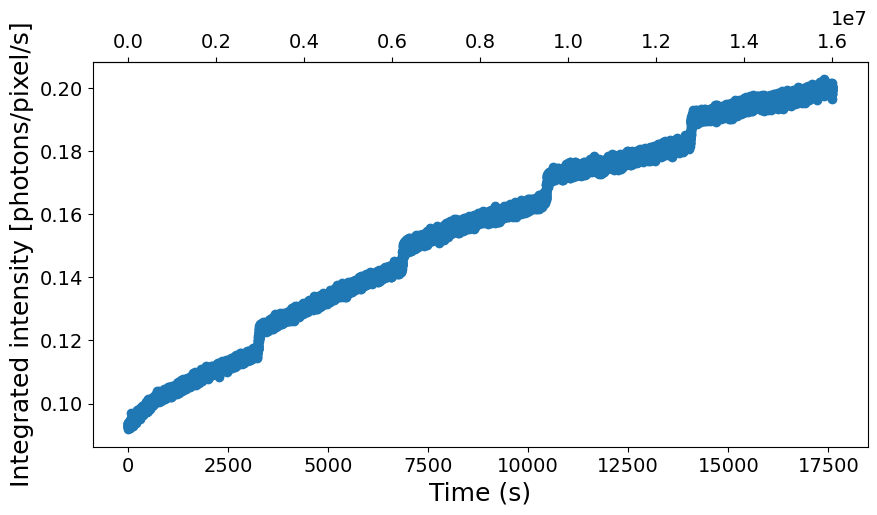

In [19]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [9]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 3.74 s)
	 | 15995 frames X 212601 pixels
	 | memory usage (np.array @ float32) = 12.668 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 28.18 s)
	 | 15995 X 15995 squared matrix
	 | memory usage (np.array @ float32) = 0.953 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.86 s)



In [10]:
############################
t1, t2 = 0, 2000
vmin, vmax = 1.0, 1.07
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [14]:
################
Nbunch = 3
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.02 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.02 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.02 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


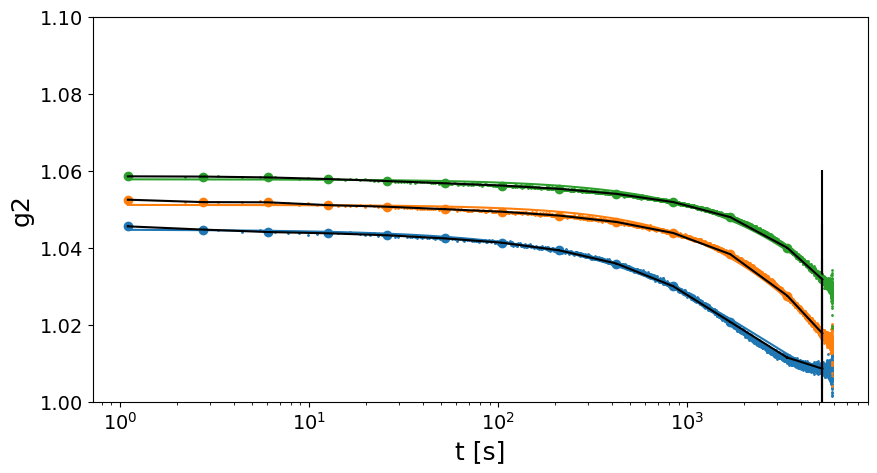

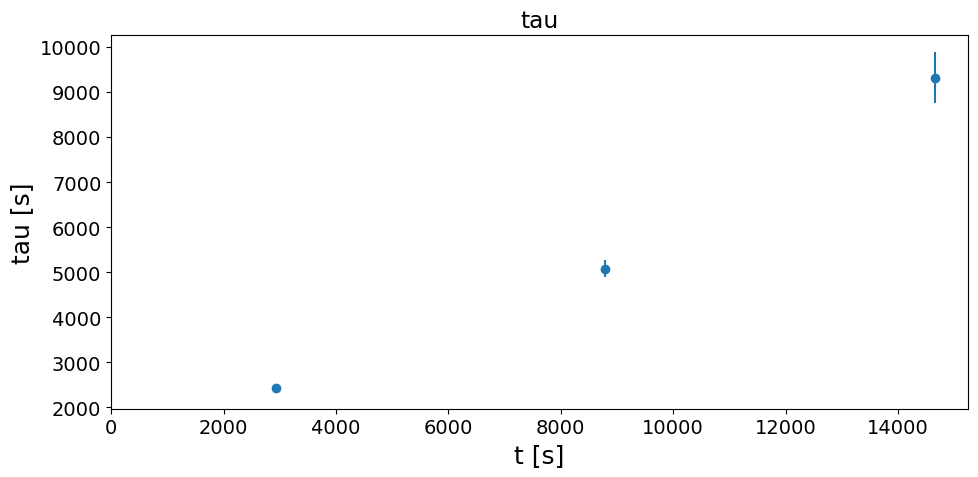

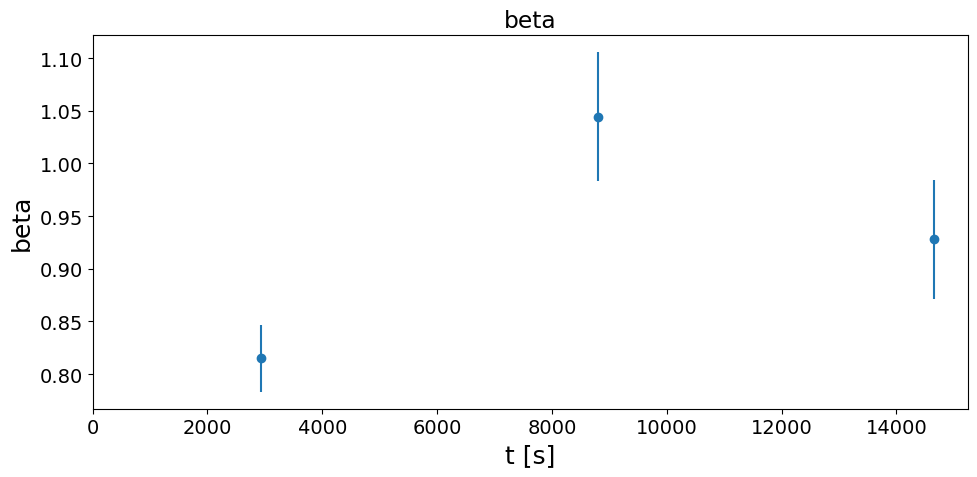

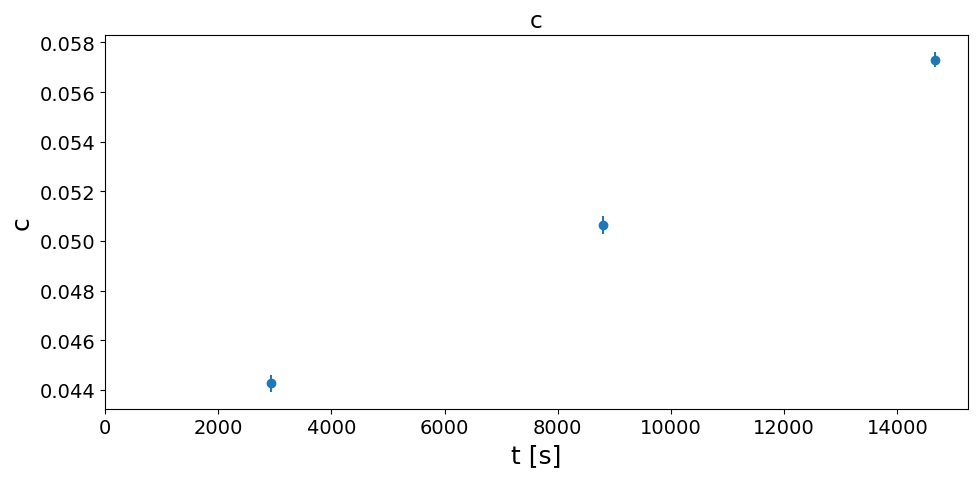

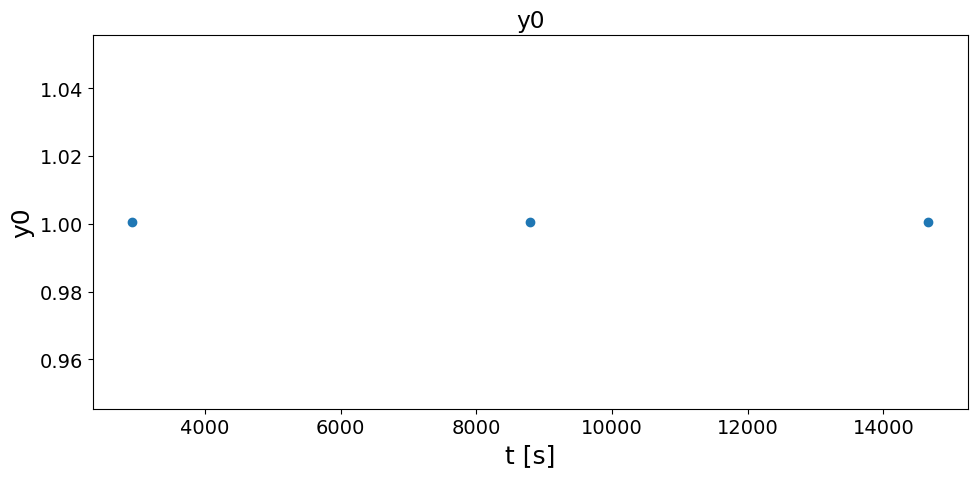

Exception ignored in: <function ResourceTracker.__del__ at 0x7fc955603c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7ff62eec3c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.0005, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k],yerr=dg2_mt[k], c='black', label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    x = t_mt[k] [(t1_fit<t_mt[k])*(t_mt[k]<t2_fit)]
    y = g2_mt[k][(t1_fit<t_mt[k])*(t_mt[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.1)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [20]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 16000128  =>  t_ff = 17600.1408
#############################



In [32]:
########################################
tt = np.linspace(0, int(t_ff), 5)
########################################

t_segments = [(tt[i], tt[i+1]) for i in range(len(tt)-1)]
Nf_segments =  [(int(t_segments[i][0]//itime), int(t_segments[i][1]//itime)) for i in range(len(t_segments))]

In [33]:
from contextlib import redirect_stdout
import io

###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments))):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i][0]
        Nff = Nf_segments[i][1]
        G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

        t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
        t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=False)
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2)

100%|██████████| 4/4 [01:24<00:00, 21.00s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


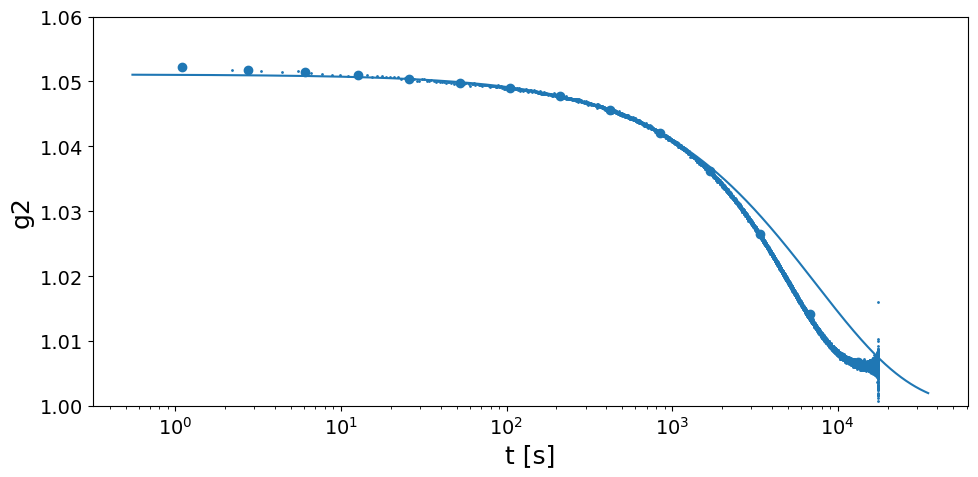

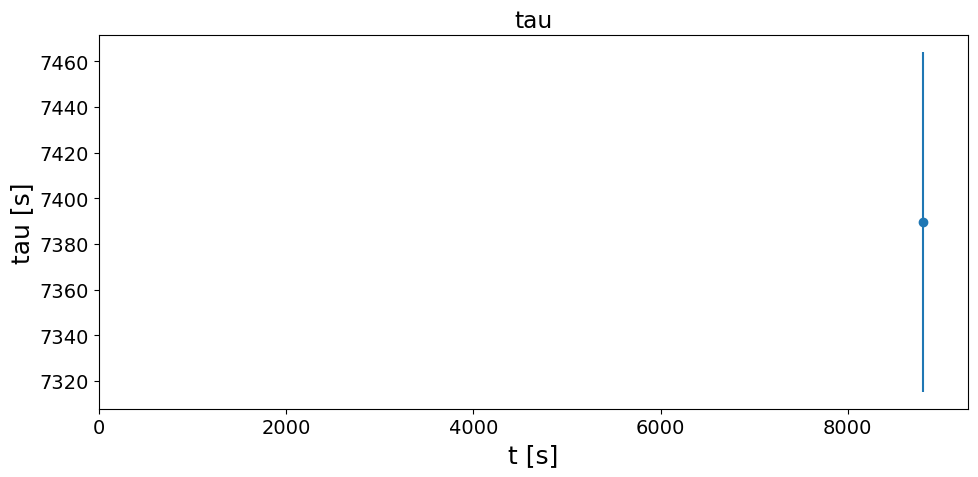

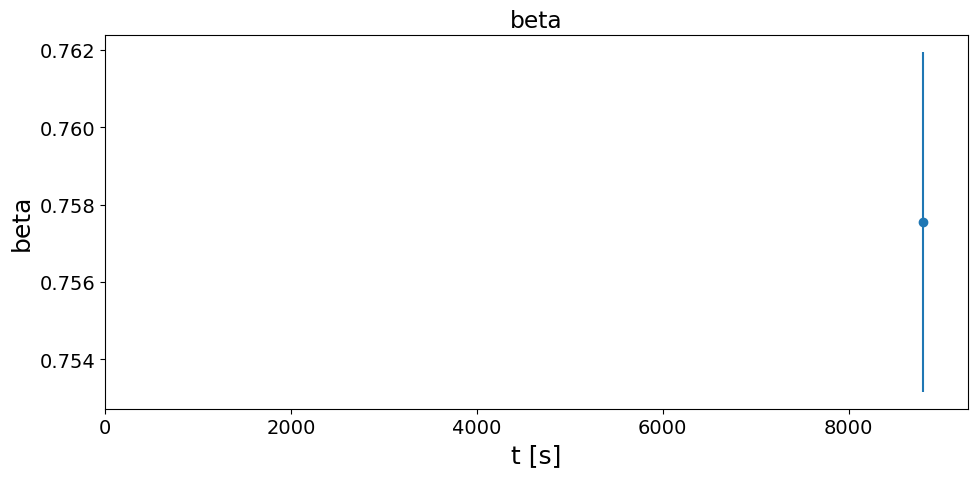

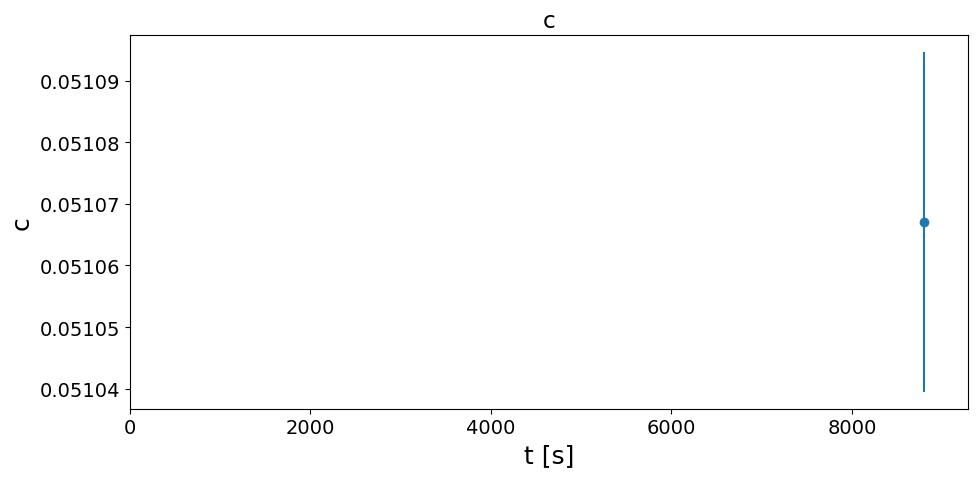

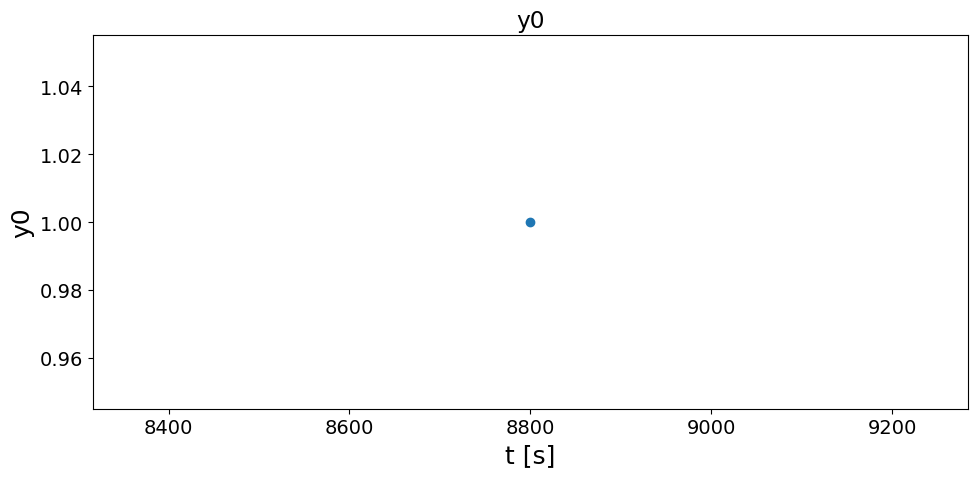

In [31]:
##################
t1_fit = 0
t2_fit = 1e3
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k])
    plt.scatter(t_mt, g2_mt, c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k])/2, np.max(t_g2[k])*2, 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.06)
#plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

### Multi-tau Correlation (TO BE REORDER!!!)

In [31]:
XPCS.print_Nf_choices(len(scan['fast_timer_period']))

       Nf = 501267    =>    log2(Nf) = 18.94
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**18                 17             47.7         239123
1    3*2**17                 16             22.0         108051
2    7*2**16                 15              8.0          42515
3   15*2**15                 14              2.0           9747
4   61*2**13                 12              0.0           1555
5  489*2**10                  9              0.0            531
----------------------------------------------------


In [36]:
##### INPUTS #####
Nfi = 0
Nff = 0 +3*2**17
sparse_depth = 13
dense_depth = 16
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

Loading frames ...
Done! (elapsed time = 0.08 s)
	 | 393216 frames X 212601 pixels
	 | sparsity = 1.05e-04
	 | memory usage (sparse.csr_array @ float32) = 0.101 GB
Computing sparse multitau G2t...


100%|██████████| 48/48 [00:09<00:00,  5.22it/s]


Done! (elapsed time = 9.2 s)
Computing dense multitau G2t...


100%|██████████| 3/3 [00:00<00:00, 47.65it/s]

Done! (elapsed time = 0.06 s)


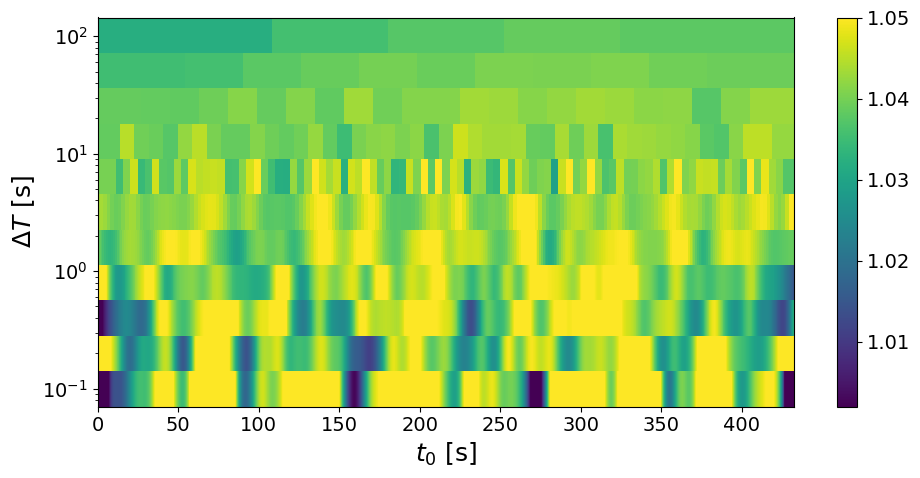

In [39]:
############################
vmin, vmax = 1.002, 1.05
lower_mt = 6
filter_layer = 12
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, filter_layer=filter_layer)

In [ ]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, tmin=None, tmax=3000)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, tmin=3000, tmax=6000)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, tmin=6000, tmax=15000)
t_mt_1, g2_mt_1, dg2_mt_1 = XPCS.get_g2mt(itime, cut1)
t_mt_2, g2_mt_2, dg2_mt_2 = XPCS.get_g2mt(itime, cut2)
t_mt_3, g2_mt_3, dg2_mt_3 = XPCS.get_g2mt(itime, cut3)

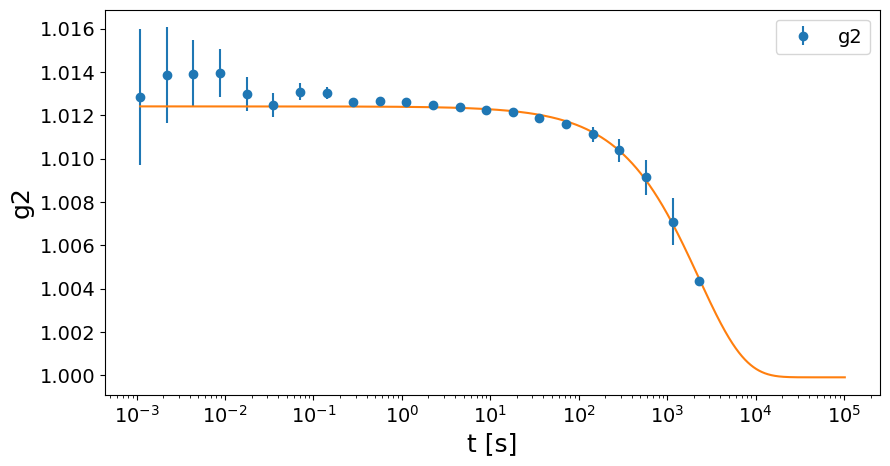

tau = 2278.4462895214124 +/- 980.3358234853137
beta = 0.8327289412512385 +/- 0.0798632634225064
c = 0.012514664192682625 +/- 0.0027602589650978534
y0 = 0.9999000000000001 +/- 0.002718059032489621


In [ ]:
##################
t1_fit = 1
t2_fit = 1e8
##################

plt.figure(figsize=(10,5))
plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')
#plt.errorbar(t_mt_1, g2_mt_1, yerr=dg2_mt_1, fmt='o', label='CUT1')
#plt.errorbar(t_mt_2, g2_mt_2, yerr=dg2_mt_2, fmt='o', label='CUT2')
#plt.errorbar(t_mt_3, g2_mt_3, yerr=dg2_mt_3, fmt='o', label='CUT3')


popt, pcov = curve_fit(decorrelation_f, t_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], g2_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], p0=[1000, .8, .04, 1], bounds=([0, 0, 0, .9999], [np.inf, np.inf, np.inf, 1.1]))
x = np.arange(np.min(t_mt), np.max(t_mt)+1e5, 1e-2)
y = decorrelation_f(x, *popt)
plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()


print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
